# Daylight Saving Effect on Heart Attack

We will use the [healthcare dataset from Kaggle](https://www.kaggle.com/datasets/prasad22/healthcare-dataset).

In [186]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
import dowhy
from dowhy import CausalModel
import os

from warnings import filterwarnings
filterwarnings('ignore')

# import necessary packages
from itertools import combinations
import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows
from numpy.random import normal
import pingouin as pg

np.random.seed(0)

# Motivation and Data Processing - 10% of the grade

Motivation, description of dataset and causal questions, description of assumptions, show true causal graph or a reasonable guess (10% grade)

In [187]:
# Move up one directory from the current working directory
os.chdir('..')

# Navigate to the 'data' directory
os.chdir('data')

file_path = 'healthcare/healthcare_dataset.csv'
# currently folder/heartattack
df = pd.read_csv(file_path)

Encode the unique medical conditions in the 'Medical Condition' feature into one-hot encoded columns.

In [188]:
print(df['Medical Condition'].value_counts())

df = pd.concat([df, pd.get_dummies(df['Medical Condition'], dtype='int')], axis=1)
df = df.drop(columns='Medical Condition')
df = df.drop(columns=['Asthma', 'Cancer', 'Arthritis', 'Obesity', 'Diabetes'])
df.head()

Asthma          1708
Cancer          1703
Hypertension    1688
Arthritis       1650
Obesity         1628
Diabetes        1623
Name: Medical Condition, dtype: int64


,Name,Age,Gender,Blood Type,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Hypertension
0,Tiffany Ramirez,81,Female,O-,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,146,Elective,2022-12-01,Aspirin,Inconclusive,0
1,Ruben Burns,35,Male,O+,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,404,Emergency,2023-06-15,Lipitor,Normal,0
2,Chad Byrd,61,Male,B-,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,292,Emergency,2019-02-08,Lipitor,Normal,0
3,Antonio Frederick,49,Male,B-,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,480,Urgent,2020-05-03,Penicillin,Abnormal,0
4,Mrs. Brandy Flowers,51,Male,O-,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,477,Urgent,2021-08-02,Paracetamol,Normal,0


Only keep first entry of the same person

In [189]:
filtered_df = df[~df['Name'].duplicated(keep='first')]

Let's see how many unique values each variable has.

In [190]:
for col_name in filtered_df.columns:
    print(f'{col_name}:{filtered_df[col_name].nunique()}')

Name:9378
Age:68
Gender:2
Blood Type:8
Date of Admission:1812
Doctor:8856
Hospital:8144
Insurance Provider:5
Billing Amount:9378
Room Number:400
Admission Type:3
Discharge Date:1832
Medication:5
Test Results:3
Hypertension:2


We decide that the following variables are irrelevant for our analysis or have arbitrary data: ```['Doctor', 'Hospital', 'Room Number', 'Discharge Date']```. We can also drop ```'Name'``` since we already filtered by the first visit of unique individuals.

In [191]:
filtered_df = filtered_df.drop(columns=['Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Name'])

Let's see the unique values of the columns with less than 10 unique values. We print the column names contianing continuous data.

In [192]:
categoricals = []

for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(f'{col_name}:{filtered_df[col_name].unique()}')
        categoricals.append(col_name)
    else:
        print(f'{col_name} is a continuous variable.')

Age is a continuous variable.
Gender:['Female' 'Male']
Blood Type:['O-' 'O+' 'B-' 'AB+' 'A+' 'AB-' 'A-' 'B+']
Date of Admission is a continuous variable.
Insurance Provider:['Medicare' 'UnitedHealthcare' 'Aetna' 'Cigna' 'Blue Cross']
Billing Amount is a continuous variable.
Admission Type:['Elective' 'Emergency' 'Urgent']
Medication:['Aspirin' 'Lipitor' 'Penicillin' 'Paracetamol' 'Ibuprofen']
Test Results:['Inconclusive' 'Normal' 'Abnormal']
Hypertension:[0 1]


We aim to introduce a binary column: assigning a value of 1 if the admission date falls within a 3-month window surrounding the annual daylight saving time change in March (a period during which individuals typically adjust their schedules due to a one-hour reduction in sleep), and 0 otherwise. Our dataset spans the years 2018-2023, and we construct a dictionary pairing each year with the specific date of the daylight saving time transition.

In [193]:
daylight_saving_dates = {
    2018: '2018-03-25',
    2019: '2019-03-31',
    2020: '2020-03-29',
    2021: '2021-03-28',
    2022: '2022-03-27',
    2023: '2023-03-26'}

In [194]:
daylight_saving_dates = {year: pd.to_datetime(date) for year, date in daylight_saving_dates.items()}

filtered_df['Date of Admission'] = pd.to_datetime(filtered_df['Date of Admission'])

filtered_df['daylight_saving_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] <= date <= daylight_saving_dates[date.year] + pd.DateOffset(months=3)
                                                                        else 0)

filtered_df['daylight_saving_before_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[date.year] >= date >= daylight_saving_dates[date.year] - pd.DateOffset(months=3)
                                                                        else 0)

Let's see how balanced is our data.

In [195]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(filtered_df[col_name].value_counts())
        print()

Female    4768
Male      4610
Name: Gender, dtype: int64

AB-    1195
B-     1187
AB+    1187
O+     1172
A-     1171
O-     1166
B+     1159
A+     1141
Name: Blood Type, dtype: int64

Cigna               1914
Aetna               1907
Blue Cross          1896
UnitedHealthcare    1852
Medicare            1809
Name: Insurance Provider, dtype: int64

Urgent       3179
Emergency    3156
Elective     3043
Name: Admission Type, dtype: int64

Penicillin     1951
Lipitor        1890
Aspirin        1849
Paracetamol    1848
Ibuprofen      1840
Name: Medication, dtype: int64

Abnormal        3231
Inconclusive    3093
Normal          3054
Name: Test Results, dtype: int64

0    7778
1    1600
Name: Hypertension, dtype: int64

0    6961
1    2417
Name: daylight_saving_march, dtype: int64

0    7143
1    2235
Name: daylight_saving_before_march, dtype: int64



In [196]:
# AFTER daylight saving time (from last sunday of march)
n_hyp = filtered_df[filtered_df.Hypertension == 1].shape[0]
n_hyp_after = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after = (n_hyp_after / n_hyp)*100

n_after_march = filtered_df[filtered_df['daylight_saving_march'] == 1].shape[0]
perc_hyp_after_total = (n_hyp_after / n_after_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension, {round(perc_hyp_after, 2)} percent was in the 3 months AFTER daylight saving in march')
print(f'This formed {round(perc_hyp_after_total, 2)} percent of the total of {round(n_after_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension, 25.31 percent was in the 3 months AFTER daylight saving in march
This formed 16.76 percent of the total of 2417 admissions for any condition in the same time period


In [120]:
# BEFORE daylight saving march
n_hyp_before = filtered_df[filtered_df.Hypertension == 1][filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before = (n_hyp_before / n_hyp)*100

n_before_march = filtered_df[filtered_df['daylight_saving_before_march'] == 1].shape[0]
perc_hyp_before_total = (n_hyp_before / n_before_march) * 100
print(f'Of the {round(n_hyp, 2)} admissions for hypertension {round(perc_hyp_before, 2)} percent was in the 3 months BEFORE daylight saving in march')
print(f'This formed {round(perc_hyp_before_total, 2)} percent of the total of {round(n_before_march, 2)} admissions for any condition in the same time period')

Of the 1600 admissions for hypertension 22.38 percent was in the 3 months BEFORE daylight saving in march
This formed 16.02 percent of the total of 2235 admissions for any condition in the same time period


We notice that 25.31% of Hypertension cases happen within 3 months after the daylight saving in March, while 22.38% of the hypertension cases happen before the daylight saving time. The trend of increased admissions in the three months following daylight saving time compared to the preceding months, may suggest a seasonal pattern which is potentially applicable to admissions for other medical conditions as well. Therefore, it is noteworthy that the proportion of Hypertension cases among all hospital admissions is also greater in the three months following the daylight saving time change compared to the three months preceding the time change. Of course this is not enough, we shall see if the daylight saving actually affects the changes of getting hypertension. We come with our own hypothesis before applying any causal discovery algorithm.

Let's examine the seasonal patterns in hospital admissions and compare it with the trends observed among patients diagnosed with Hypertension.

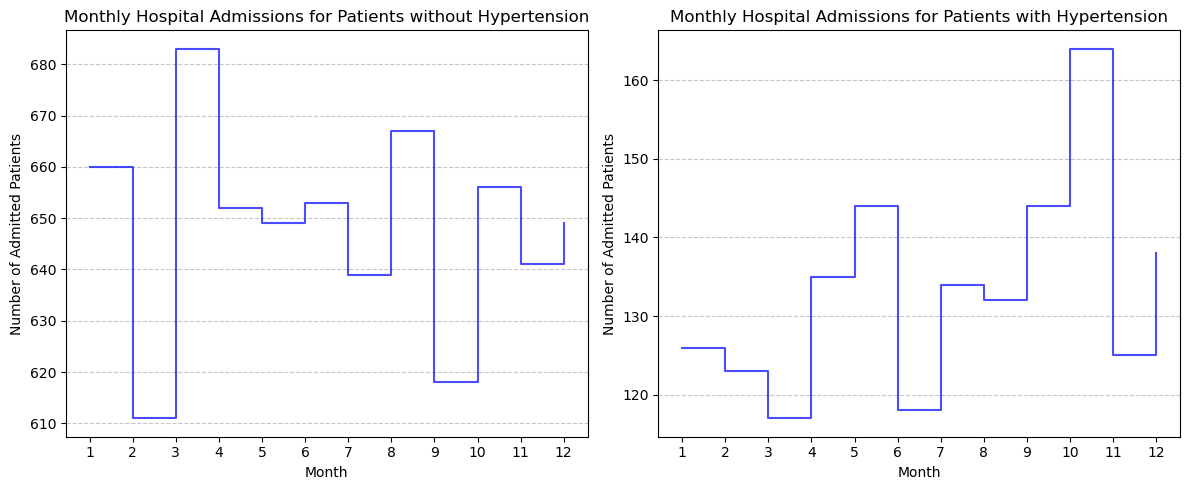

In [197]:
# Note: y-axis does not start at 0

plt.figure(figsize=(12, 5))

# admitted patients without hypertension
plt.subplot(1, 2, 1)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 0].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients without Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# admitted patients with hypertension
plt.subplot(1, 2, 2)
doy_frequency = filtered_df['Date of Admission'][filtered_df.Hypertension == 1].apply(lambda x: x.month).value_counts().sort_index(ascending=True)
plt.step(doy_frequency.index, doy_frequency.values, where='post', color='blue', alpha=0.7)
plt.xticks(range(1, 13))
plt.title('Monthly Hospital Admissions for Patients with Hypertension')
plt.xlabel('Month')
plt.ylabel('Number of Admitted Patients')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


TEMPorary Conclusion of graphs:

In the graph depicting the number of patients admitted to the hospital for Hypertension, the two months following the end of March (considering that daylight saving time starts on the last Sunday of March) exhibit higher admission counts compared to the preceding months. On the other hand, when examining all admissions irrespective of medical conditions, the month of February shows significantly fewer admissions. However, January displays admission counts similar to those observed in the months immediately following the end of March.

In [198]:
for col_name in filtered_df.columns:
    print(col_name)

Age
Gender
Blood Type
Date of Admission
Insurance Provider
Billing Amount
Admission Type
Medication
Test Results
Hypertension
daylight_saving_march
daylight_saving_before_march


We can already form some hypothesis. We can motivate to follow this work in this case.

In [148]:
# old options:
# ('daylight_saving_march', 'Medical Condition'),
# ('Age', 'daylight_saving_march'),
# ('Admission Type', 'daylight_saving_march'),
# # ('Age', 'Asthma'),              # might improve by ageing
# # ('Age', 'Arthritis'),           # gets worse
# # ('Age', 'Diabetes'),            # gets worse
# # ('Age', 'Obesity'),             # gets worse
# # ('Age', 'Cancer'),              # gets worse
# # ('Gender', 'Asthma'),           #?
# # ('Gender', 'Arthritis'),        #?
# # ('Gender', 'Diabetes'),         #?
# # ('Gender', 'Obesity'),          #?
# # ('Gender', 'Cancer'),
# # ('Asthma', 'Medication'),
# # ('Arthritis', 'Medication'),
# # ('Diabetes', 'Medication'),
# # ('Obesity', 'Medication'),
# # ('Cancer', 'Medication'),
# # ('Asthma', 'Test Results'),
# # ('Arthritis', 'Test Results'),
# # ('Diabetes', 'Test Results'),
# # ('Obesity', 'Test Results'),
# # ('Cancer', 'Test Results'),
# ('Admission Type', 'Test Results'),
# ('Billing Amount', 'Hypertension'),
# ('daylight_saving_march', 'Age'),   # older people more admitted during colder months? US data FORMS loop
# ('daylight_saving_march', 'Asthma'),    # might co-occur with pollen allergy and influeneced by
# ('daylight_saving_march', 'Obesity'), 


# new potential candidates:

('Age', 'Medication')       # age might directly influence if medication is prescribed or not.
('Gender', 'Medication')    # same reasoning
('Gender', 'Insurance Provider') # More focused on men/women??? not likely

('Gender', 'Insurance Provider')

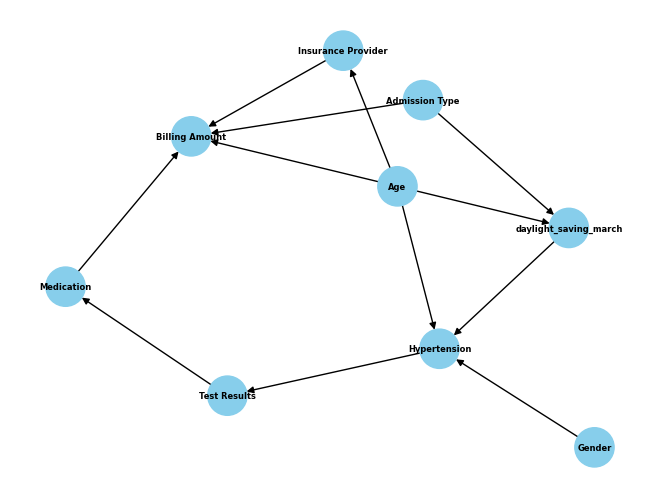

In [199]:
graph_variables = ['Age', 'Gender', 'Insurance Provider', 'Billing Amount', 
                   'Admission Type', 'Medication', 'Test Results', 'Hypertension', 'daylight_saving_march'] #, 'Arthritis', 'Asthma', 'Cancer', 'Diabetes', 'Obesity',]

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('Insurance Provider', 'Billing Amount'),
    ('Age', 'Billing Amount'),                      # older people require more care for same treatment
    ('Age', 'Insurance Provider'),                  # marketing or preference by age
    ('Age', 'Hypertension'),                        # blood pressure rises and likelihood of hypertension 
    ('Gender', 'Hypertension'),                     # hormonal reasons maybe influnece the likelihood of hypertension
    # ('Hypertension', 'Medication'),               # through medication?           
    ('Hypertension', 'Test Results'),           
    # ('Test Results', 'Billing Amount'),           # through medication
    ('Test Results', 'Medication'),
    ('Medication', 'Billing Amount'),               # billing amount is dependent on the prescribed medication
    ('daylight_saving_march', 'Hypertension'),      # hypothesis: due to lack of sleep
    ('Admission Type', 'Billing Amount'),           # emerGgency requires more money
    # debatable treatment incomming arrows
    ('Admission Type', 'daylight_saving_march'),    # ??
    ('Age', 'daylight_saving_march'),               # ?? confounder
]


G.add_edges_from(edges)

pos = nx.kamada_kawai_layout(G)
node_size = [800 if node in graph_variables else 200 for node in G.nodes]
node_color = ['skyblue' if node in graph_variables else 'lightgray' for node in G.nodes]

nx.draw(G, pos, with_labels=True, font_size=6, node_size=node_size, node_color=node_color, font_color='black', font_weight='bold', arrowsize=10)

plt.tight_layout()
plt.show()

In [200]:
# Check for cycles
list(nx.simple_cycles(G))

# Exploratory Data Analysis - 15% of the grade

Testing correlations/conditional independences (15% grade, follow Tutorial 1&2)

Find all paths from between two nodes: ```daylight_saving_march``` and ```Hypertension```.

Number of paths found: 7


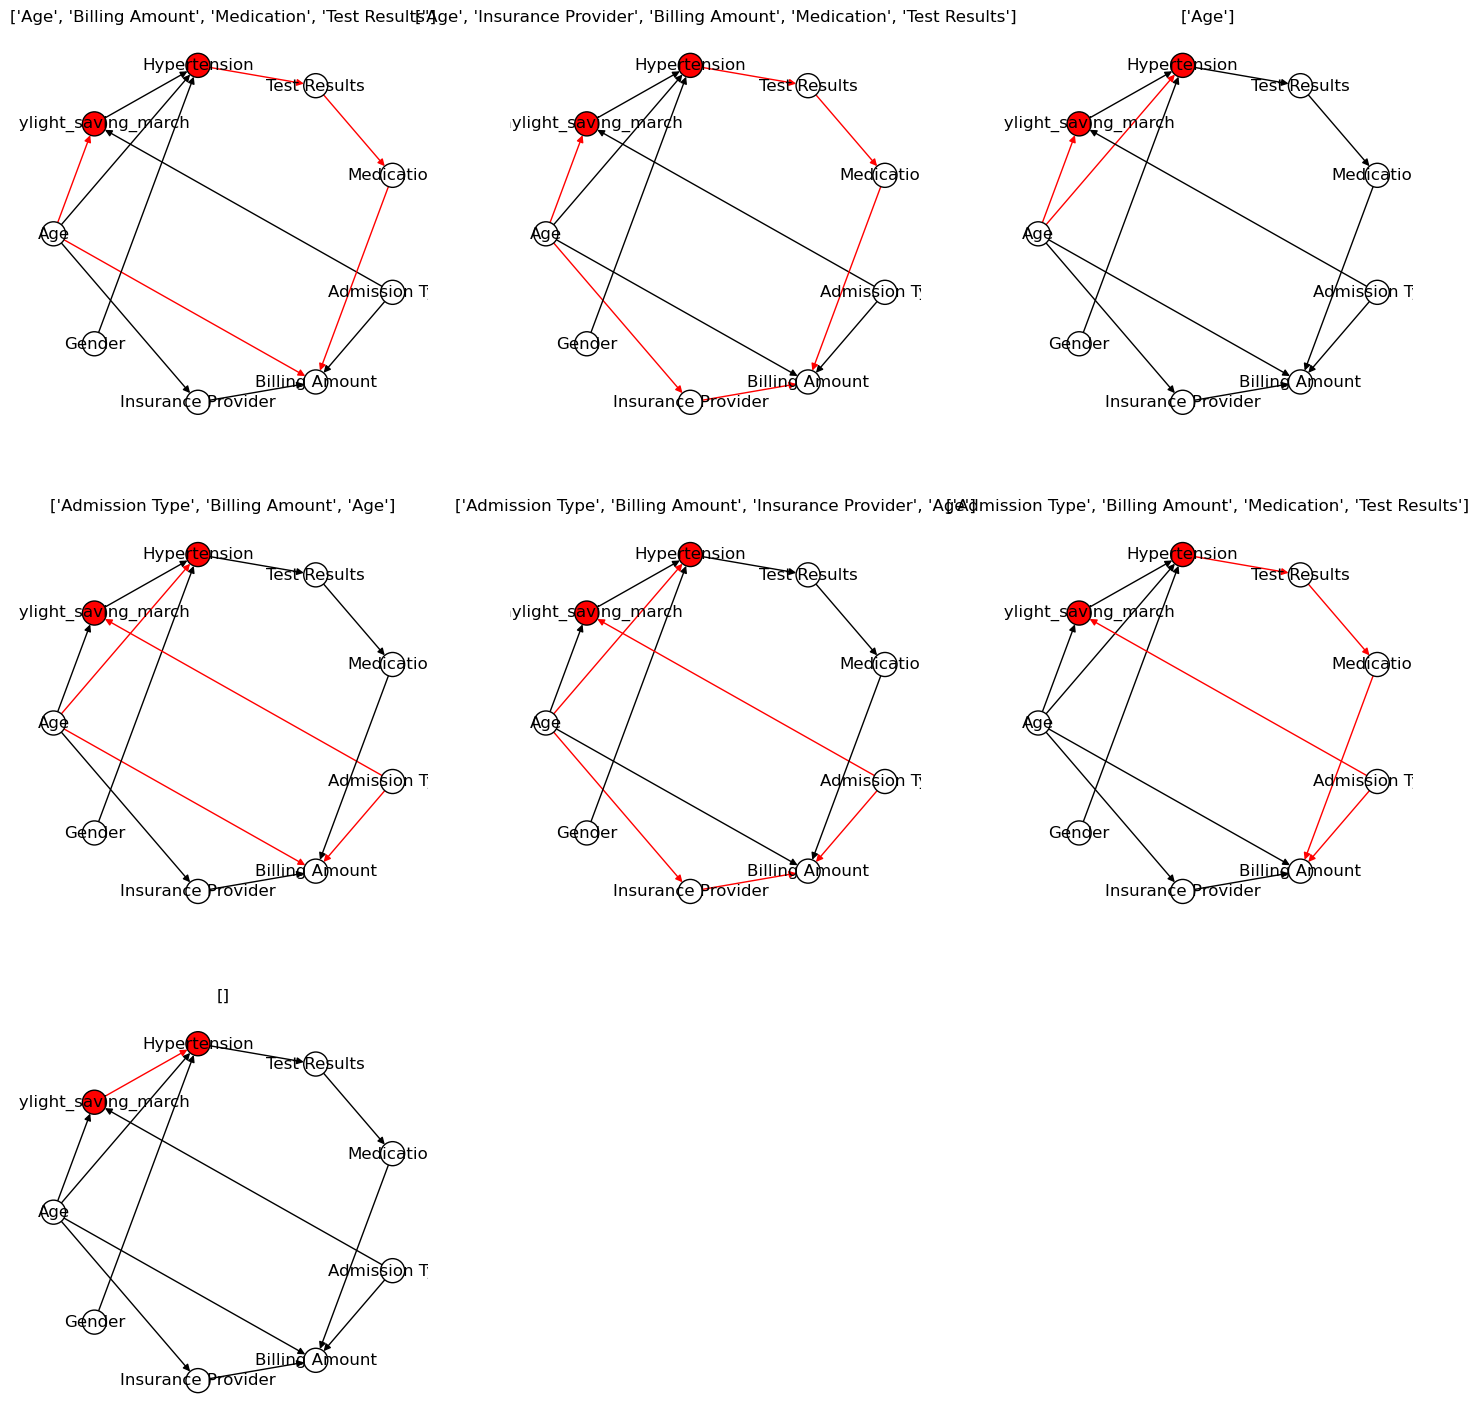

In [201]:
all_paths = list(nx.all_simple_paths(G.to_undirected(), source='daylight_saving_march', target='Hypertension'))
print('Number of paths found:', len(all_paths))

if len(all_paths) > 20:
    all_paths = all_paths[:20]
    
n_cols = 3
n_rows = (len(all_paths) - 1) // n_cols + 1
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 6 * n_rows))

for i, path in enumerate(all_paths):
    col = i % n_cols
    row = i // n_cols
    edges_on_path = [set([source, target]) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if set(edge) in edges_on_path else 'black' for edge in G.edges()]  
    nx.draw_shell(G, with_labels=True, node_color=['w' if i < len(graph_variables) - 2 else 'r' for i in range(len(graph_variables))], edgecolors='black', ax=axs[row, col], edge_color=edge_color)
    axs[row, col].set_title(path[1:-1])
    
# hide empty plots
for i in range(len(all_paths), n_rows * n_cols):
    axs.flatten()[i].axis('off')

In [202]:
from itertools import combinations

X = ['daylight_saving_march']
Y = ['Hypertension']

Z = [variable for variable in graph_variables if variable not in X + Y]

all_comb = []
for r in range(1, len(Z) + 1):
    all_comb.extend(combinations(Z, r))

# all will be false because they have a direct edge right now in the graph
for combination in all_comb:
    print('Node daylight_saving_march and Hypertension are d-separated by {}: {}'.format(path, nx.algorithms.d_separated(G=G, x=set(['daylight_saving_march']), y=set(['Hypertension']), z=set(combination))))

Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']: False
Node daylight_saving_march and Hypertension are d-separated by ['daylight_saving_march', 'Hypertension']

## Independence tests

In [203]:
from itertools import permutations
import pingouin as pg

def test_all(df, vars):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [204]:
def encode_categoricals(df):
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()

    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
            
    return df

In [205]:
# in order to have the partial_corr independence test work we need to have numericals => encode categorical data
df_encoded = encode_categoricals(filtered_df)
df_encoded

,Age,Gender,Blood Type,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Hypertension,daylight_saving_march,daylight_saving_before_march
0,81,0,7,2022-11-17,3,37490.983364,0,0,1,0,0,0
1,35,1,6,2023-06-01,4,47304.064845,1,2,2,0,1,0
2,61,1,5,2019-01-09,3,36874.896997,1,2,2,0,0,1
3,49,1,5,2020-05-02,3,23303.322092,2,4,0,0,1,0
4,51,1,7,2021-07-09,4,18086.344184,2,3,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,83,1,0,2022-07-29,4,39606.840083,0,1,0,0,0,0
9996,47,0,2,2022-01-06,1,5995.717488,1,1,2,0,0,1
9997,54,1,5,2022-07-01,1,49559.202905,0,1,2,0,0,0
9998,84,1,0,2020-02-06,4,25236.344761,2,4,2,0,0,1


In [206]:
test_all(df_encoded, graph_variables)

Age and Gender: p-value is 0.5118936213292858
Age and Insurance Provider: p-value is 0.9306652789231536
Age and Billing Amount: p-value is 0.38770579907837277
Age and Admission Type: p-value is 0.5411272036726902
Age and Medication: p-value is 0.38150116377421794
Age and Test Results: p-value is 0.3908643552750751
Age and Hypertension: p-value is 0.1412517922042081
Age and daylight_saving_march: p-value is 0.6182469334790157
Gender and Age: p-value is 0.5118936213292854
Gender and Insurance Provider: p-value is 0.05167704764915206
Gender and Billing Amount: p-value is 0.6399470393661827
Gender and Admission Type: p-value is 0.9020256900524015
Gender and Medication: p-value is 0.5923715947692116
Gender and Test Results: p-value is 0.4194962861873397
Gender and Hypertension: p-value is 0.31032412828410555
Gender and daylight_saving_march: p-value is 0.3483360391577216
Insurance Provider and Age: p-value is 0.9306652789231536
Insurance Provider and Gender: p-value is 0.05167704764915206
I

# Identify estimands for backdoor, frontdoor criterion and IVs - 20% of the grade

If they apply, or explain why they don't apply (20% grade, follow Tutorial 3 and 4)

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from the treatment variable.

Given a CBN $(G = (\mathbf{V}, \mathbf{E}), p)$ and a distinct pair of variables $X_i, Y_j \in \mathbf{V}$, a set $\mathbf{Z} \subseteq \mathbf{V} \setminus \{i,j\}$ satisfies the
**backdoor criterion** for estimating the causal effect of $X_i$ on $X_j$ if:
- $\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$, **and**
- $\mathbf{Z}$ blocks all backdoor paths from $i$ to $j$ (all paths that start with an arrow into $i \gets ... j$)


In [157]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

df_encoded.head()

# creating a copy of our graph G that is undirected
H = G.to_undirected()
all_possible_paths = list(nx.all_simple_paths(H, 'daylight_saving_march', 'Hypertension'))
for path in all_possible_paths:
    print(path)

['daylight_saving_march', 'Age', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']
['daylight_saving_march', 'Age', 'Insurance Provider', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']
['daylight_saving_march', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Insurance Provider', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']
['daylight_saving_march', 'Hypertension']


In [158]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'daylight_saving_march','Hypertension')

In [159]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['daylight_saving_march', 'Age', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']
['daylight_saving_march', 'Age', 'Insurance Provider', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']
['daylight_saving_march', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Insurance Provider', 'Age', 'Hypertension']
['daylight_saving_march', 'Admission Type', 'Billing Amount', 'Medication', 'Test Results', 'Hypertension']


In [160]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

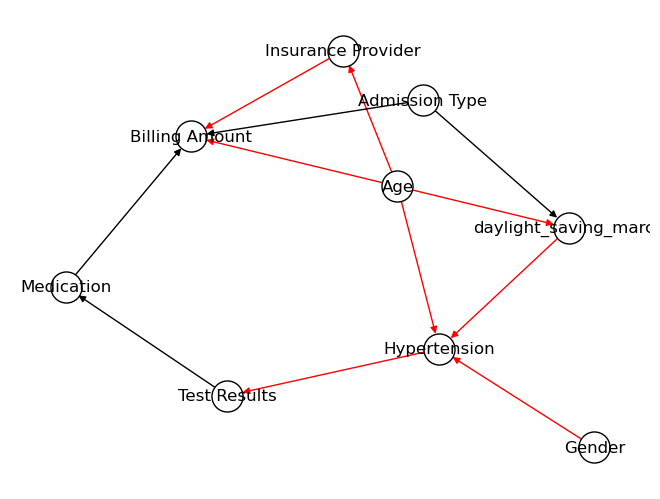

In [161]:
colors = ['r', 'r', 'r', 'r', 'r', 'r', 'black', 'black', 'black', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [162]:
def get_adjustment_variables(path):
    # we create empty (for now) lists for our colliders and non-colliders
    # we also create a variable for the length of the path
    colliders = np.array([])
    non_colliders = []
    path_len = len(path)

    # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
    for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
        # if there is an arrow pointing into node1 from both sides on the path, it is a collider
        if G.has_edge(node0, node1) and G.has_edge(node2, node1):
            colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
    # we flatten the list of list
    colliders = colliders.flatten()
    # any node on the path (excluding the source and target) that is not a collider is a non-collider
    non_colliders = [x for x in path[1:-1] if x not in colliders]
    # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
    adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 
    return adjustment_variables


get_adjustment_variables(backdoor_paths[0])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, M...",[Billing Amount],"[Age, Medication, Test Results]"


We now can see that we need either:

1. Not to condition on $Medicatioin$ or its descendants [None], or
2. Condition on at least one of [Age, Medical Condition]

In [163]:
get_adjustment_variables(backdoor_paths[1])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, M...",[Billing Amount],"[Age, Medication, Test Results]"
1,"[daylight_saving_march, Age, Insurance Provide...",[Billing Amount],"[Age, Insurance Provider, Medication, Test Res..."


We now can see that we need either:

1. Not to condition on $Medication$ or its descendants [None], or
2. Condition on at least one of the non-colliders: ...

In [164]:
get_adjustment_variables(backdoor_paths[2])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, M...",[Billing Amount],"[Age, Medication, Test Results]"
1,"[daylight_saving_march, Age, Insurance Provide...",[Billing Amount],"[Age, Insurance Provider, Medication, Test Res..."
2,"[daylight_saving_march, Age, Hypertension]",[],[Age]


We now can see that we need either:

1. Not to condition on $Medication$ or its descendants [None], or
2. Condition on at least one of the non-colliders: ...

In [165]:
get_adjustment_variables(backdoor_paths[3])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Billing Amount, M...",[Billing Amount],"[Age, Medication, Test Results]"
1,"[daylight_saving_march, Age, Insurance Provide...",[Billing Amount],"[Age, Insurance Provider, Medication, Test Res..."
2,"[daylight_saving_march, Age, Hypertension]",[],[Age]
3,"[daylight_saving_march, Admission Type, Billin...",[Billing Amount],"[Admission Type, Age]"


There are no colliders on this path, so we need to condition on Admission type.

DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with data, but since we are only worried about the backdoor criterion for now, we can give it meaningless data (remember: the estimands are graph-specific, and don't rely on the data).

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['daylight_saving_march'] on outcome ['Hypertension']
INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


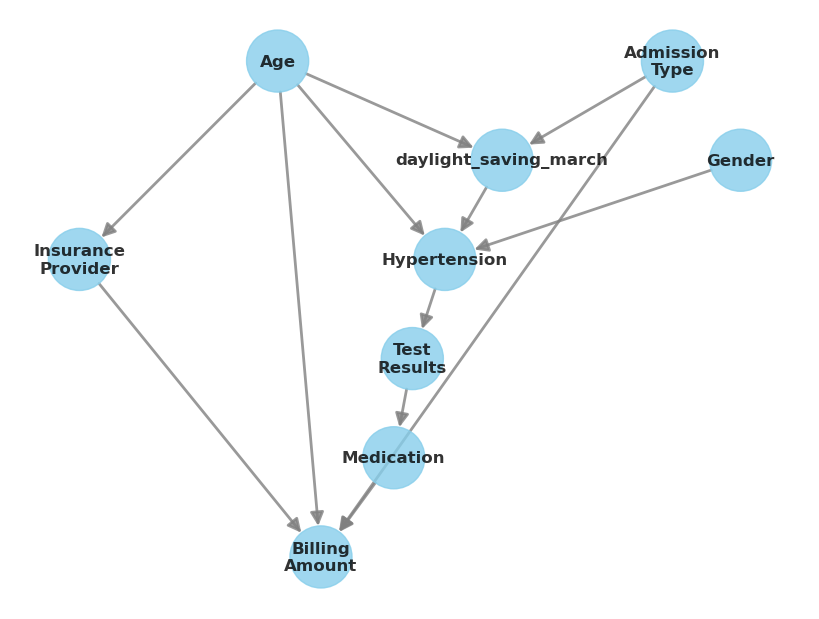

In [166]:
import dowhy
from dowhy import CausalModel


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
    data = df_encoded,
    treatment='daylight_saving_march', 
    outcome='Hypertension',
    graph=gml_graph
)
model.view_model()

In [167]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Admission Type']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                       ⎛        d                                 ⎞
E⎢─────────────────(Hypertension)⋅⎜─────────────────([daylight_saving_march])⎟
 ⎣d[Admission Type]               ⎝d[Admission Type]                         ⎠

-1⎤
  ⎥
  ⎥
  ⎦
Estimand assumption 1, As-if-random: If U→→Hypertension then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬(

In [168]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('Admission Type', 'Gender', 'Age', 'Insurance Provider')},
 {'backdoor_set': ('Age',)}]

### Frontdoor Criterion

The frontdoor criterion is similar to the backdoor criterion, only now we move along 'forward' paths rather than 'backwards' paths. The below definition and example are from: https://medium.data4sci.com/causal-inference-part-xii-front-door-criterion-38bec5172f3e.

A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$

Let's consider the same graph as in week 3 and identify possible frontdoor criterion adjustment sets for the effect of $X$ on $Y$.

INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


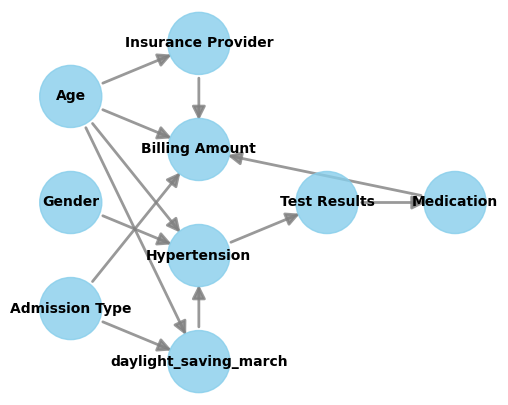

In [169]:
# we extract the CausalGraph object from our CausalModel object
our_causal_graph = model._graph
our_causal_graph.view_graph()

Now we can find an adjustment set that satisfies the frontdoor criterion. We first need all directed paths from $X$ to $Y$, as our adjustment set needs to intercept all such paths.

# function for finding all directed paths between the two nodes given
our_causal_graph.get_all_directed_paths(['daylight_saving_march'], ['Medical Condition'])

In [145]:
# function that finds backdoor paths from the first node to the second
x_w_backdoor_paths = our_causal_graph.get_backdoor_paths('daylight_saving_march', # the mediator)
x_w_backdoor_paths

SyntaxError: incomplete input (3410128677.py, line 3)

In [ ]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from X to W
for path in x_w_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are not conditioning on any nodes, so give it the empty set
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = []))

path_is_blocked

NameError: name 'x_w_backdoor_paths' is not defined

In [ ]:
w_y_backdoor_paths = our_causal_graph.get_backdoor_paths('W', 'Y')
w_y_backdoor_paths

NodeNotFound: source node W not in graph

In [ ]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from W to Y
for path in w_y_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are conditioning on the set [X]
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = ['X']))

path_is_blocked

NameError: name 'w_y_backdoor_paths' is not defined

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Admission Type']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                       ⎛        d                                 ⎞
E⎢─────────────────(Hypertension)⋅⎜─────────────────([daylight_saving_march])⎟
 ⎣d[Admission Type]               ⎝d[Admission Type]                         ⎠

-1⎤
  ⎥
  ⎥
  ⎦
Estimand assumption 1, As-if-random: If U→→Hypertension then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬(

# Estimate the causal effects - 15% of the grade

(e.g. linear, inverse propensity weighting, two stage linear-regression etc) to the estimands you have previously identified (15% grade, follow Tutorial 4)

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Admission Type']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                       ⎛        d                                 ⎞
E⎢─────────────────(Hypertension)⋅⎜─────────────────([daylight_saving_march])⎟
 ⎣d[Admission Type]               ⎝d[Admission Type]                         ⎠

-1⎤
  ⎥
  ⎥
  ⎦
Estimand assumption 1, As-if-random: If U→→Hypertension then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬(

Let's use the set identified by the backdoor criterion. We can thus estimate the effect of daylight_saving_march on Medical Condition when we condition on Age.

Let's first try estimate the effect without conditioning on these extra variables. Suppose we expect (know) that the effect is linear. We can then apply a linear estimator to find the effect. We will use linear regression.

In [170]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
num_samples = df_encoded.shape[0]
v0_vals = df_encoded['daylight_saving_march'].values.reshape(num_samples, 1)
y_vals = df_encoded['Hypertension'].values.reshape(num_samples, 1)

In [171]:
# we import the LinearRegression object from sklearn
from sklearn.linear_model import LinearRegression

# we fit a linear regression model with v0 and y, and check what the estimated linear effect is
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[-0.00410764]])

In [172]:
W0_vals = df_encoded['Age'].values.reshape(num_samples, 1)
# we need to combine all of the variables we're including into one array
v0_W0_W1_vals = np.concatenate((v0_vals, W0_vals), axis = 1)
v0_W0_W1_vals

array([[ 0, 81],
       [ 1, 35],
       [ 0, 61],
       ...,
       [ 0, 54],
       [ 0, 84],
       [ 0, 20]])

In [173]:
# we fit the linear regression with the extra variables included
linear_regressor.fit(v0_W0_W1_vals, y_vals)
linear_regressor.coef_

array([[-0.0040405 , -0.00029125]])

In [174]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Gender


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age+daylight_saving_march*Gender
Target units: ate

## Estimate
Mean value: -0.004074249066051361

Causal Estimate is -0.004074249066051361


In [175]:
# using the backdoor adjustment set and propensity score stratification
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:propensity_score_stratification
INFO:dowhy.causal_estimator:Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Hypertension~daylight_saving_march+Age
INFO:dowhy.causal_estimator:'num_strata' selected as 468.9
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 234
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 117


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                 
────────────────────────(E[Hypertension|Age])
d[daylight_saving_march]                     
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Hypertension then P(Hypertension|daylight_saving_march,Age,U) = P(Hypertension|daylight_saving_march,Age)

## Realized estimand
b: Hypertension~daylight_saving_march+Age
Target units: ate

## Estimate
Mean value: -0.0039014883845779644

Causal Estimate is -0.0039014883845779644


In [ ]:
# using the instrumental variables
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:instrumental_variable
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡       d                     ⎤  -1⎡       d                              ⎤
E⎢───────────────(Hypertension)⎥⋅E  ⎢───────────────(daylight_saving_march)⎥
 ⎣dAdmission Type              ⎦    ⎣dAdmission Type                       ⎦
Estimand assumption 1, As-if-random: If U→→Hypertension then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬({Admission Type}→Hypertension)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['daylight_saving_march'] is affected in the same way by common causes of ['daylight_saving_march'] and ['Hypertension']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['Hypertension'] is affected in th

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                       ⎛        d                                 ⎞
E⎢─────────────────(Hypertension)⋅⎜─────────────────([daylight_saving_march])⎟
 ⎣d[Admission Type]               ⎝d[Admission Type]                         ⎠

-1⎤
  ⎥
  ⎥
  ⎦
Estimand assumption 1, As-if-random: If U→→Hypertension then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬({Admission Type}→Hypertension)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡       d                     ⎤  -1⎡       d                              ⎤
E⎢───────────────(Hypertension)⎥⋅E  ⎢───────────────(daylight_saving_march)⎥
 ⎣dAdmission Type 

# Causal discovery results - 20% of the grade

for at least one constraint-based (e.g. SGS, PC) and score-based algorithm (e.g. GES), explain why it works or it doesn't and what is identifiable (20% grade, follow Tutorials 5 and 6)

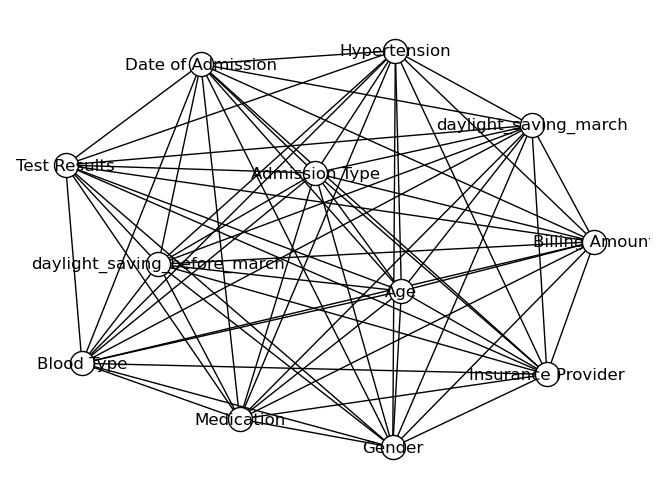

In [207]:
nodes =  list(df_encoded.columns)
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

nx.draw(skeleton, with_labels=True, node_color='w', edgecolors ='black')

In [208]:
try:
    df_encoded.drop('Date of Admission', axis=1, inplace=True)
except:
    pass

df_encoded.head()


,Age,Gender,Blood Type,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,Hypertension,daylight_saving_march,daylight_saving_before_march
0,81,0,7,3,37490.983364,0,0,1,0,0,0
1,35,1,6,4,47304.064845,1,2,2,0,1,0
2,61,1,5,3,36874.896997,1,2,2,0,0,1
3,49,1,5,3,23303.322092,2,4,0,0,1,0
4,51,1,7,4,18086.344184,2,3,2,0,0,0


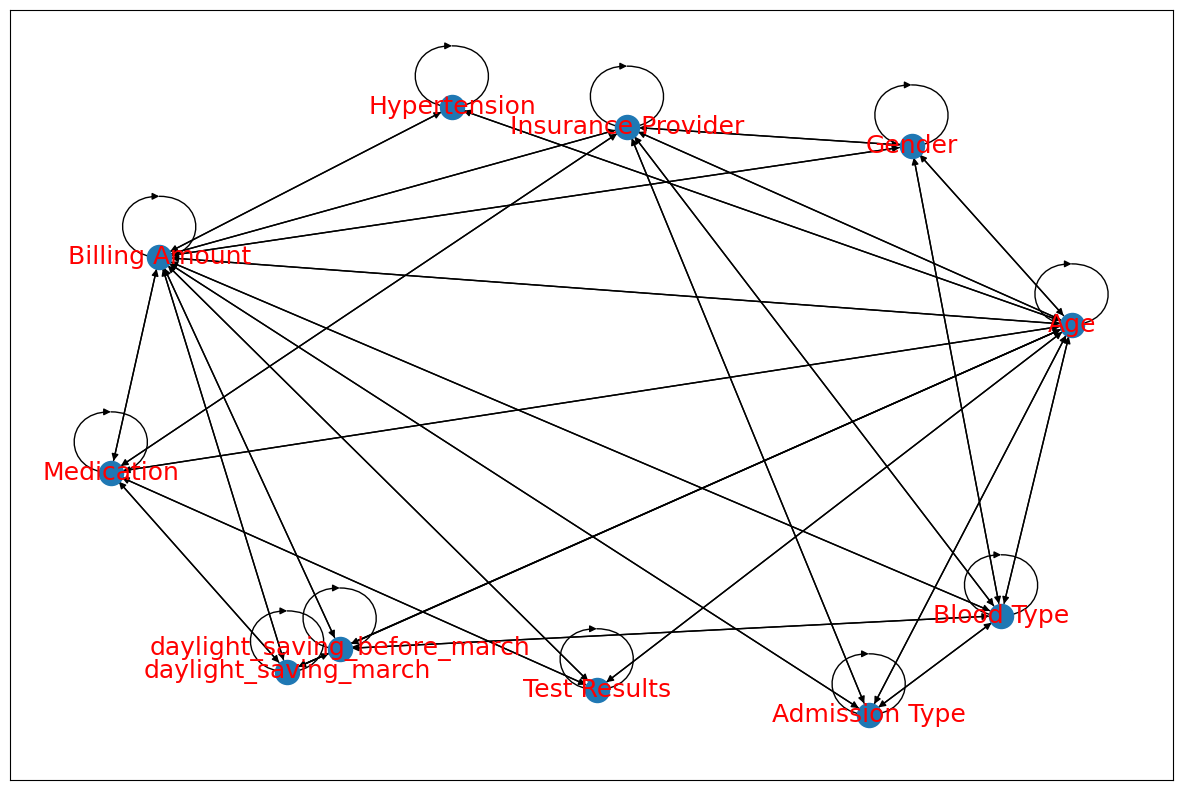

In [209]:
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to data
skeleton = glasso.predict(df_encoded)# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

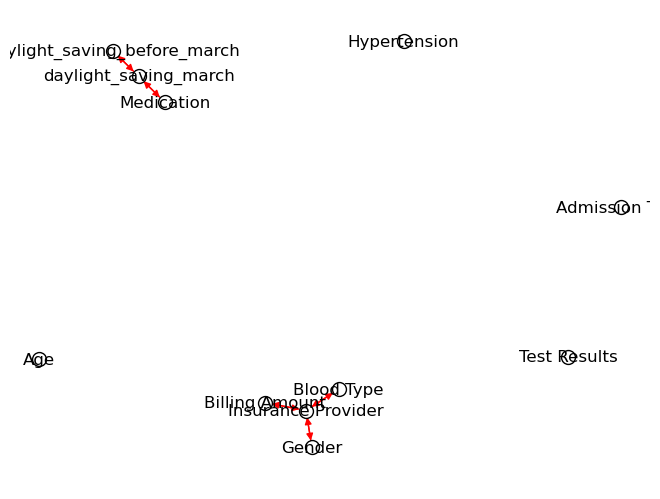

In [212]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=0.1)

pc_graph = pc.create_graph_from_data(df_encoded)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

In [211]:
pc_graph.edges()

OutEdgeView([('Blood Type', 'Insurance Provider'), ('Insurance Provider', 'Blood Type'), ('daylight_saving_march', 'daylight_saving_before_march'), ('daylight_saving_before_march', 'daylight_saving_march')])

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0]]


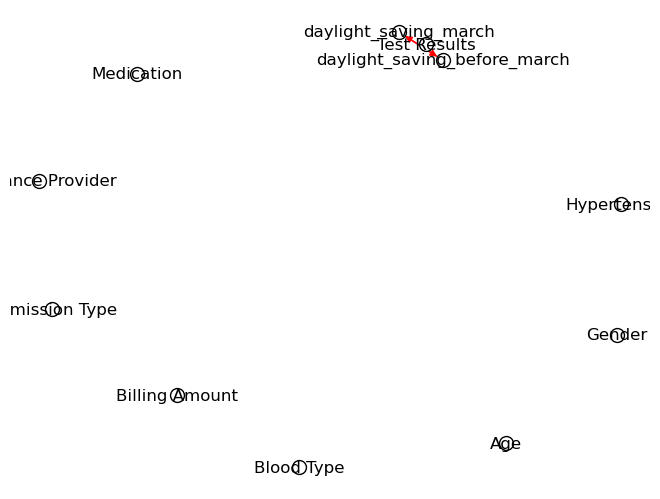

In [216]:
new_skeleton = cdt.utils.graph.remove_indirect_links(skeleton, alg='aracne')
model = cdt.causality.graph.GES()
output_graph = model.predict(df_encoded, new_skeleton)
print(nx.adjacency_matrix(output_graph).todense())

nx.draw(output_graph, with_labels=True, node_size=100, node_color='w', edgecolors ='black', edge_color=colors)

# Validation and sensitivity analysis - 20% of the grade

(e.g. refutation analysis in DoWhy) and Discussion on the assumptions and results (20% grade)